In [ ]:
import pandas as pd
import shap
!pip install optuna
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Load the dataset
df = pd.read_csv("dropout.csv")

# Encode categorical variables (if any)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target (assuming last column is the target)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Map target labels to class names
class_labels = {0: "graduate", 1: "dropout", 2: "enrolled"}
y = y.map(class_labels)

# Feature Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(chi2, k=5)
X_selected = selector.fit_transform(X, y)

# Synthetic Oversampling
smote = SMOTE(random_state=318945)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=318945)

# Polynomial Features for Logistic Regression
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


Model: Random Forest Baseline
Accuracy: 0.6953
F1 Score: 0.6948
Confusion Matrix:
[[336  71  51]
 [ 74 258  88]
 [ 44  76 328]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.64      0.61      0.63       420
     dropout       0.70      0.73      0.72       448
    enrolled       0.74      0.73      0.74       458

    accuracy                           0.70      1326
   macro avg       0.69      0.69      0.69      1326
weighted avg       0.69      0.70      0.69      1326



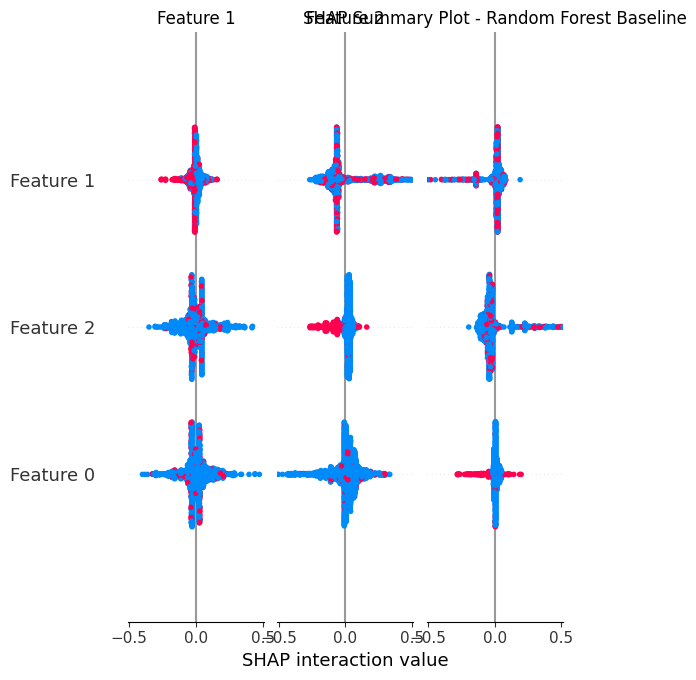


Model: Logistic Regression Baseline
Accuracy: 0.6456
F1 Score: 0.6486
Confusion Matrix:
[[273 135  50]
 [ 53 249 118]
 [ 12 102 334]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.59      0.55       420
     dropout       0.67      0.75      0.70       448
    enrolled       0.81      0.60      0.69       458

    accuracy                           0.65      1326
   macro avg       0.66      0.64      0.65      1326
weighted avg       0.67      0.65      0.65      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

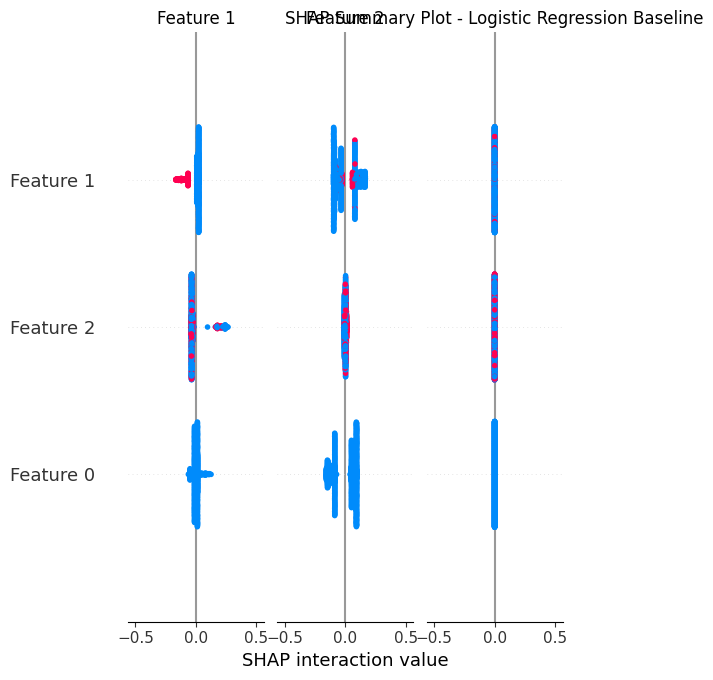


Model: SVM Baseline
Accuracy: 0.6357
F1 Score: 0.6386
Confusion Matrix:
[[278 128  52]
 [ 54 236 130]
 [ 16 103 329]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.56      0.53       420
     dropout       0.64      0.73      0.69       448
    enrolled       0.80      0.61      0.69       458

    accuracy                           0.64      1326
   macro avg       0.65      0.63      0.64      1326
weighted avg       0.65      0.64      0.64      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

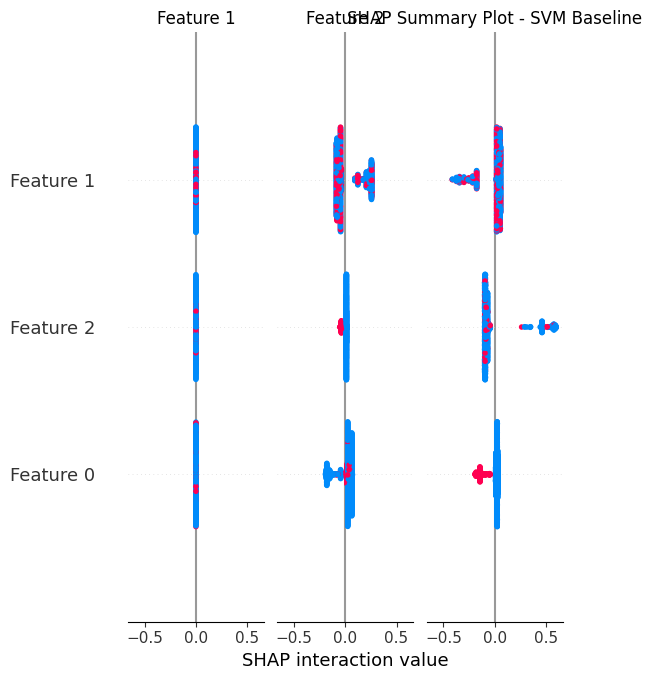


Model: Naïve Bayes Baseline
Accuracy: 0.6305
F1 Score: 0.6232
Confusion Matrix:
[[281 102  75]
 [ 56 178 186]
 [ 17  54 377]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.53      0.42      0.47       420
     dropout       0.59      0.84      0.69       448
    enrolled       0.79      0.61      0.69       458

    accuracy                           0.63      1326
   macro avg       0.64      0.63      0.62      1326
weighted avg       0.64      0.63      0.62      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

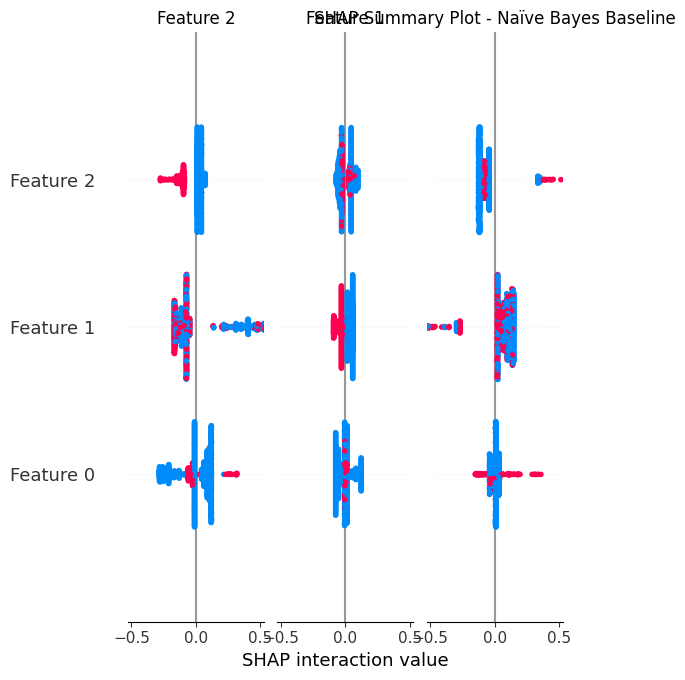


Model: Random Forest Modified #1
Accuracy: 0.7149
F1 Score: 0.7140
Confusion Matrix:
[[345  68  45]
 [ 69 258  93]
 [ 34  69 345]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.65      0.61      0.63       420
     dropout       0.71      0.77      0.74       448
    enrolled       0.77      0.75      0.76       458

    accuracy                           0.71      1326
   macro avg       0.71      0.71      0.71      1326
weighted avg       0.71      0.71      0.71      1326



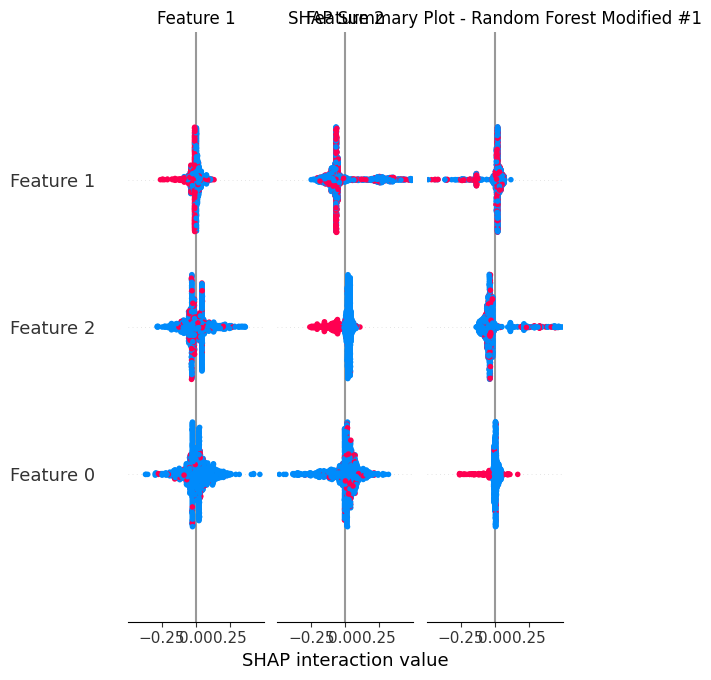


Model: Logistic Regression Modified #1
Accuracy: 0.6335
F1 Score: 0.6365
Confusion Matrix:
[[273 135  50]
 [ 55 235 130]
 [ 12 104 332]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.50      0.56      0.53       420
     dropout       0.65      0.74      0.69       448
    enrolled       0.80      0.60      0.68       458

    accuracy                           0.63      1326
   macro avg       0.65      0.63      0.63      1326
weighted avg       0.65      0.63      0.64      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

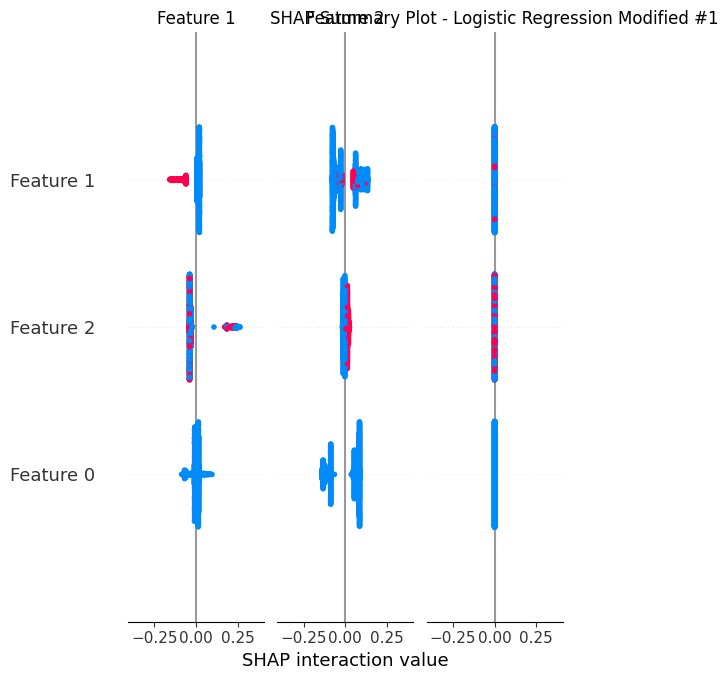


Model: SVM Modified #1
Accuracy: 0.6425
F1 Score: 0.6440
Confusion Matrix:
[[276 132  50]
 [ 49 231 140]
 [ 16  87 345]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.55      0.53       420
     dropout       0.64      0.77      0.70       448
    enrolled       0.81      0.60      0.69       458

    accuracy                           0.64      1326
   macro avg       0.66      0.64      0.64      1326
weighted avg       0.66      0.64      0.64      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

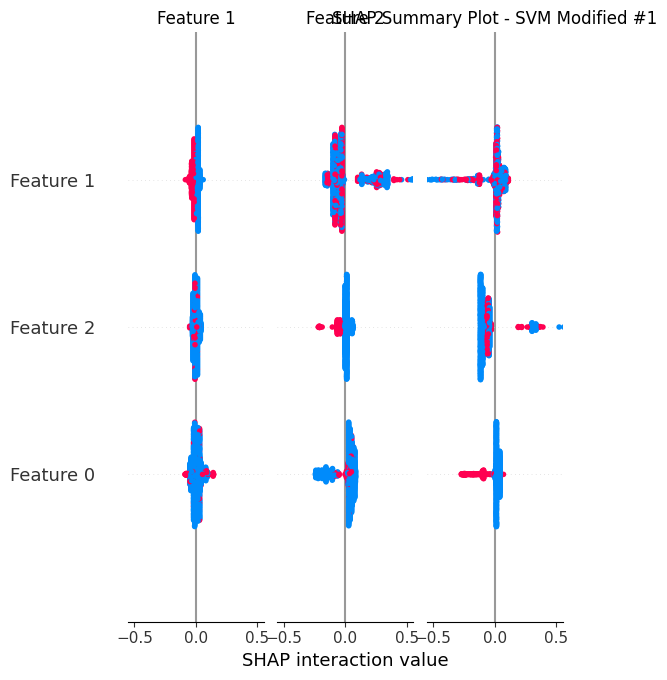


Model: Naïve Bayes Modified #1
Accuracy: 0.6207
F1 Score: 0.6136
Confusion Matrix:
[[277 105  76]
 [ 55 173 192]
 [ 16  59 373]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.41      0.46       420
     dropout       0.58      0.83      0.69       448
    enrolled       0.80      0.60      0.69       458

    accuracy                           0.62      1326
   macro avg       0.63      0.62      0.61      1326
weighted avg       0.63      0.62      0.61      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

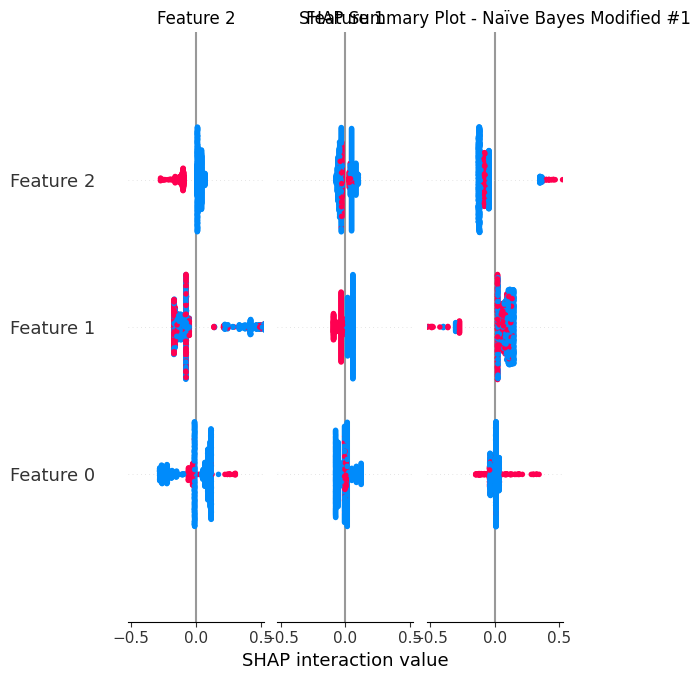

[I 2025-02-20 13:30:53,968] A new study created in memory with name: no-name-a463cb60-8905-499e-a33e-a5189ff6eebc
<ipython-input-6-d96f26206de5>:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform("C", 1e-3, 1e3),
[I 2025-02-20 13:30:54,821] Trial 0 finished with value: 0.5691330288030141 and parameters: {'model': 'SVM', 'C': 0.049242949415932796}. Best is trial 0 with value: 0.5691330288030141.
<ipython-input-6-d96f26206de5>:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  model = GaussianNB(var_smoothing=trial.suggest_loguniform("var_smoothing", 1e-9, 1e-1))
[I 2025-02-20 13:30:54,848] Trial 1 finished with value: 0.6231786518292287 and param

Best parameters: {'model': 'Random Forest', 'n_estimators': 133, 'max_depth': 14}

Model: Random Forest Optimized
Accuracy: 0.7172
F1 Score: 0.7174
Confusion Matrix:
[[333  81  44]
 [ 59 272  89]
 [ 33  69 346]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.64      0.65      0.65       420
     dropout       0.72      0.77      0.75       448
    enrolled       0.78      0.73      0.75       458

    accuracy                           0.72      1326
   macro avg       0.72      0.72      0.72      1326
weighted avg       0.72      0.72      0.72      1326



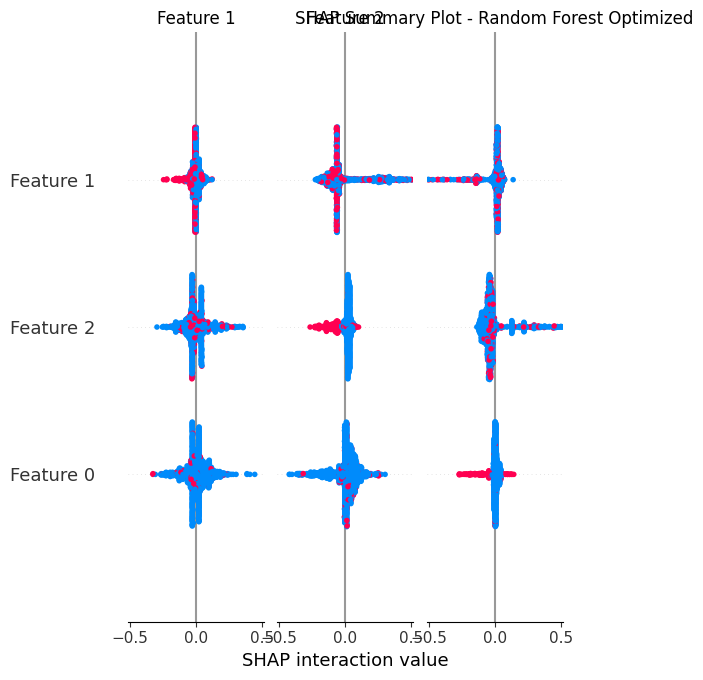


Model: Logistic Regression Optimized
Accuracy: 0.6456
F1 Score: 0.6486
Confusion Matrix:
[[273 135  50]
 [ 53 249 118]
 [ 12 102 334]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.59      0.55       420
     dropout       0.67      0.75      0.70       448
    enrolled       0.81      0.60      0.69       458

    accuracy                           0.65      1326
   macro avg       0.66      0.64      0.65      1326
weighted avg       0.67      0.65      0.65      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

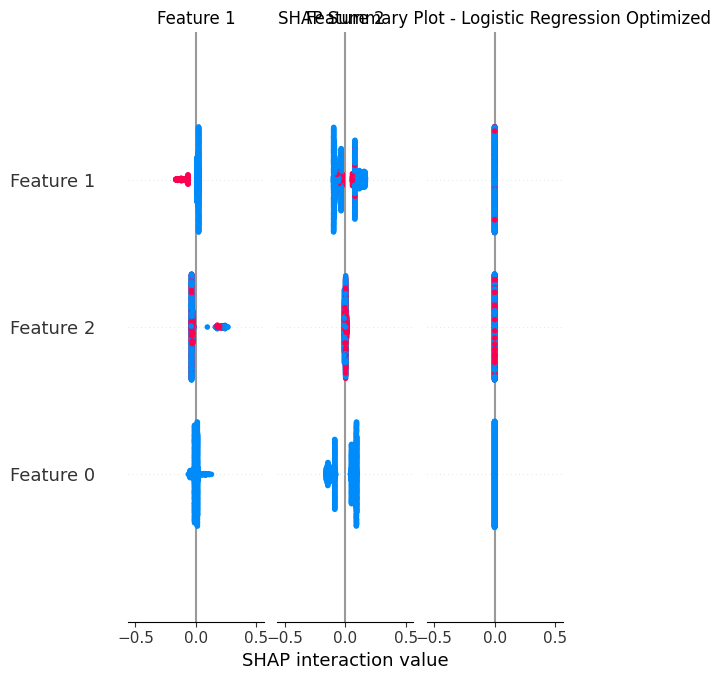


Model: SVM Optimized
Accuracy: 0.6357
F1 Score: 0.6386
Confusion Matrix:
[[278 128  52]
 [ 54 236 130]
 [ 16 103 329]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.51      0.56      0.53       420
     dropout       0.64      0.73      0.69       448
    enrolled       0.80      0.61      0.69       458

    accuracy                           0.64      1326
   macro avg       0.65      0.63      0.64      1326
weighted avg       0.65      0.64      0.64      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

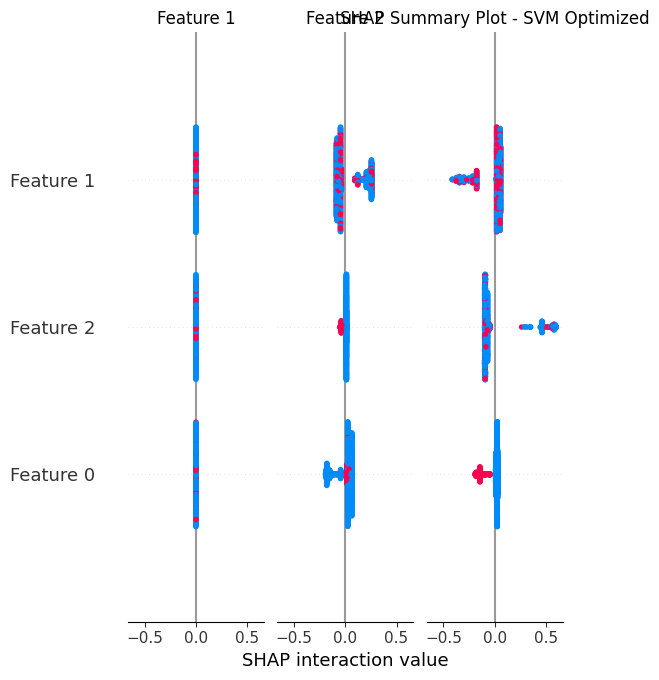


Model: Naïve Bayes Optimized
Accuracy: 0.6305
F1 Score: 0.6232
Confusion Matrix:
[[281 102  75]
 [ 56 178 186]
 [ 17  54 377]]
Classification Report:
              precision    recall  f1-score   support

    graduate       0.53      0.42      0.47       420
     dropout       0.59      0.84      0.69       448
    enrolled       0.79      0.61      0.69       458

    accuracy                           0.63      1326
   macro avg       0.64      0.63      0.62      1326
weighted avg       0.64      0.63      0.62      1326



  0%|          | 0/1326 [00:00<?, ?it/s]

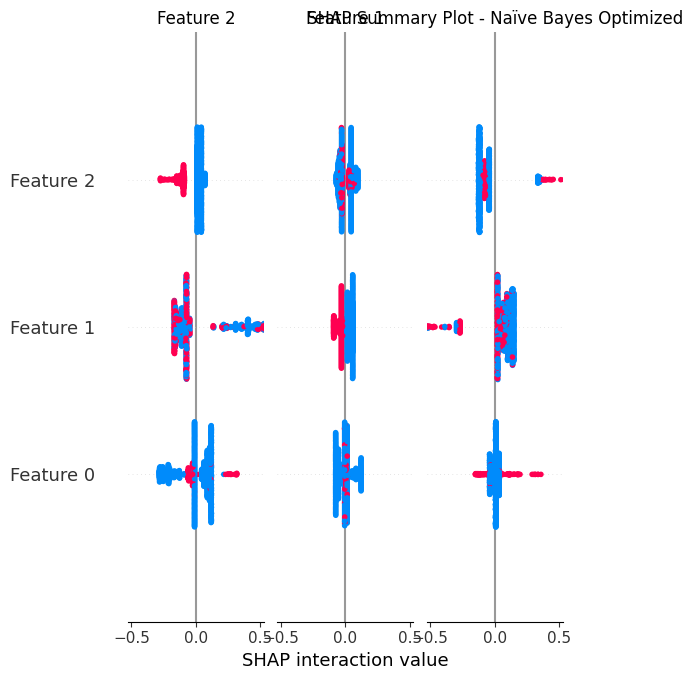

GaussianNB()

In [ ]:
def train_evaluate_shap(model, model_name, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred, labels=["graduate", "dropout", "enrolled"])
    report = classification_report(y_test, y_pred, target_names=["graduate", "dropout", "enrolled"])

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    # SHAP analysis
    # Use KernelExplainer for non-tree-based models
    if isinstance(model, (RandomForestClassifier,)):  # Check if the model is tree-based
        explainer = shap.TreeExplainer(model)
    else:
        # Sample background data for KernelExplainer to speed up computation
        background_data = shap.sample(X_train, 100)  # Use 100 representative samples
        explainer = shap.KernelExplainer(model.predict_proba, background_data)

    shap_values = explainer(X_test)

    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Summary Plot - {model_name}")
    plt.show()

    return model

# Baseline Models
rf_baseline = train_evaluate_shap(RandomForestClassifier(random_state=318945), "Random Forest Baseline", X_train, X_test)
log_reg_baseline = train_evaluate_shap(LogisticRegression(random_state=318945), "Logistic Regression Baseline", X_train_poly, X_test_poly)
svm_baseline = train_evaluate_shap(SVC(kernel="linear", random_state=318945, probability=True), "SVM Baseline", X_train, X_test)
nb_baseline = train_evaluate_shap(GaussianNB(), "Naïve Bayes Baseline", X_train, X_test)

# Modified Models #1
rf_modified1 = train_evaluate_shap(RandomForestClassifier(min_samples_split=5, class_weight="balanced", random_state=318945), "Random Forest Modified #1", X_train, X_test)
log_reg_modified1 = train_evaluate_shap(LogisticRegression(C=0.5, max_iter=1000, random_state=318945), "Logistic Regression Modified #1", X_train_poly, X_test_poly)
svm_modified1 = train_evaluate_shap(SVC(C=0.5, kernel="rbf", random_state=318945, probability=True), "SVM Modified #1", X_train, X_test)
nb_modified1 = train_evaluate_shap(GaussianNB(var_smoothing=1e-2), "Naïve Bayes Modified #1", X_train, X_test)

# Hyperparameter optimization with Optuna
def objective(trial):
    model_name = trial.suggest_categorical("model", ["Random Forest", "Logistic Regression", "SVM", "Naïve Bayes"])
    if model_name == "Random Forest":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 10, 200),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            random_state=318945
        )
    elif model_name == "Logistic Regression":
        model = LogisticRegression(
            C=trial.suggest_loguniform("C", 1e-3, 1e3),
            max_iter=1000,
            random_state=318945
        )
    elif model_name == "SVM":
        model = SVC(
            C=trial.suggest_loguniform("C", 1e-3, 1e3),
            kernel="linear",
            random_state=318945
        )
    else:
        model = GaussianNB(var_smoothing=trial.suggest_loguniform("var_smoothing", 1e-9, 1e-1))

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average="weighted")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Best parameters:", study.best_params)

# Train and evaluate Optimized Models
rf_optimized = RandomForestClassifier(n_estimators=study.best_params.get("n_estimators", 100), max_depth=study.best_params.get("max_depth", None), random_state=318945)
log_reg_optimized = LogisticRegression(C=study.best_params.get("C", 1.0), max_iter=1000, random_state=318945)
svm_optimized = SVC(C=study.best_params.get("C", 1.0), kernel="linear", random_state=318945, probability=True)
nb_optimized = GaussianNB(var_smoothing=study.best_params.get("var_smoothing", 1e-9))

train_evaluate_shap(rf_optimized, "Random Forest Optimized", X_train, X_test)
train_evaluate_shap(log_reg_optimized, "Logistic Regression Optimized", X_train_poly, X_test_poly)
train_evaluate_shap(svm_optimized, "SVM Optimized", X_train, X_test)
train_evaluate_shap(nb_optimized, "Naïve Bayes Optimized", X_train, X_test)

In [7]:
# Model performance data
data = {
    "Model": ["Random Forest", "Logistic Regression", "SVM", "Naïve Bayes"],
    "Accuracy (Baseline)": [69.23, 63.20, 63.57, 63.05],
    "F1 Score (Baseline)": [69.16, 63.76, 63.86, 62.32],
    "Accuracy (Modified #1)": [71.49, 63.50, 64.25, 62.14],
    "F1 Score (Modified #1)": [71.40, 63.80, 64.40, 61.45],
    "Accuracy (Modified #2)": [71.72, 64.56, 63.57, 63.05],
    "F1 Score (Modified #2)": [71.74, 64.86, 63.86, 62.32],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
print(df.to_string(index=False))

              Model  Accuracy (Baseline)  F1 Score (Baseline)  Accuracy (Modified #1)  F1 Score (Modified #1)  Accuracy (Modified #2)  F1 Score (Modified #2)
      Random Forest                69.23                69.16                   71.49                   71.40                   71.72                   71.74
Logistic Regression                63.20                63.76                   63.50                   63.80                   64.56                   64.86
                SVM                63.57                63.86                   64.25                   64.40                   63.57                   63.86
        Naïve Bayes                63.05                62.32                   62.14                   61.45                   63.05                   62.32
